There are three general cases where we want to construct a scheduler to make observations:

1) We have a large area we would like to observe (in one or more bands) in an intelligent way.  In this case, we typically define a survey footprint with HEALpix maps and use one or more `BlobSurvey` objects to execute the observations. This is how we execute the main LSST survey, including things like the Wide Fast Deep area and the North Ecliptic Spur. 
2) We have a list of pointings we would like executed at a specific time. This case can be done with `ScriptedSurvey` objects. 
3) We would like to select the best choice from a list of potential pointings. This doesn't come up for the main LSST survey, but can be useful for AuxTel and commissioning studies.  

In [1]:
import numpy as np
import healpy as hp
import matplotlib.pylab as plt
%matplotlib inline
import pandas as pd

from rubin_scheduler.scheduler import sim_runner
from rubin_scheduler.scheduler.model_observatory import ModelObservatory
from rubin_scheduler.scheduler.surveys import PointingsSurvey
from rubin_scheduler.scheduler.utils import ObservationArray
from rubin_scheduler.scheduler.schedulers import CoreScheduler

from astropy import units
from astropy.coordinates import Angle

import pickle

In [2]:
# Read in a list of pointings we might want to observe
tiles = pd.read_csv('auxtel_tiles.txt', delimiter=' ')
tiles

,Survey,Name,RA,Dec
0,LATISS_POLE,001,00:00:00.00,-89:53:48.23
1,LATISS_POLE,002,02:10:54.54,-89:53:48.23
2,LATISS_POLE,003,04:21:49.09,-89:53:48.23
3,LATISS_POLE,004,06:32:43.63,-89:53:48.23
4,LATISS_POLE,005,08:43:38.18,-89:53:48.23
...,...,...,...,...
794,AUXTEL_PHOTO_IMAGING,Photo1800-1_028,18:00:46.04,-24:57:20.25
795,AUXTEL_PHOTO_IMAGING,Photo1800-1_029,18:00:49.96,-24:57:20.25
796,AUXTEL_PHOTO_IMAGING,Photo1800-1_030,18:00:53.88,-24:57:20.25
797,AUXTEL_PHOTO_IMAGING,Photo1800-1_031,18:00:57.79,-24:57:20.25


In [3]:
# Convert pointings to an observation array
obs = ObservationArray(n=len(tiles))
obs['scheduler_note'] = tiles['Survey'] + tiles['Name']
obs['RA'] = Angle(tiles['RA'],unit=units.hourangle).rad
obs['dec'] = Angle(tiles['Dec'],unit=units.degree).rad

obs['flush_by_mjd'] = 0.
obs['nexp'] = 1
obs['band'] = 'r'
obs['exptime'] = 60.

In [4]:
# load the potential observations into a PointingsSurvey
# by default, the PointingsSurvey will stick on a detailer that 
# sets each observation to the parallactic angle. For now we'll clobber 
# that so all the observations get taken with rotTelPos=0
ps = PointingsSurvey(obs, detailers=[])
sched = CoreScheduler([ps])


In [5]:
# Try observing with the survey for 3 days
mo = ModelObservatory(downtimes="ideal")
mo, sched, completed_obs = sim_runner(mo, sched, sim_duration=3)


/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/surveys/pointings_survey.py:270: RuntimeWarning: invalid value encountered in divide
  result = np.floor(1.0 + self.n_obs / sum_obs)


progress = 33.35%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/skybrightness_pre/sky_model_pre.py:352: UserWarning: Requested MJD between sunrise and sunset, returning closest maps
  warnings.warn("Requested MJD between sunrise and sunset, returning closest maps")


progress = 100.07%Skipped 0 observations
Flushed 0 observations from queue for being stale
Completed 976 observations
ran in 0 min = 0.0 hours


Text(0.5, 1.0, 'Completed observations')

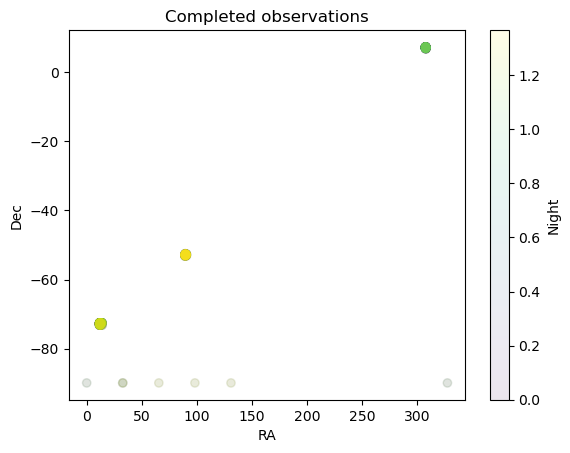

In [6]:
# plot the observations that were taken
fig, ax = plt.subplots()
ack = ax.scatter(np.degrees(completed_obs['RA']), np.degrees(completed_obs['dec']),
            c=completed_obs['mjd']-completed_obs['mjd'].min(), alpha=0.1)
cb = plt.colorbar(ack)
cb.set_label('Night')
ax.set_xlabel('RA')
ax.set_ylabel('Dec')
ax.set_title('Completed observations')

In [7]:
conditions = mo.return_conditions()
conditions

Conditions at 0x1543ade50
============================
nside:  32   
site:  LSST   
exptime:  30.0   
lmst:  [22.23953009]   
clouds:  None   
current_band:  r   
mounted_bands:  ['g', 'r', 'i', 'z', 'y']   
night:  3   
wind_speed:  None   
wind_direction:  None   
len(scheduled_observations):  0   
len(queue):  None   
moonPhase:  88.10391882191729   
bulk_cloud:  [0.25]   
targets_of_opportunity:  None   
cumulative_azimuth_rad:  0   

Positions (radians)
-------------------
| name      |        alt |         az |           RA |        decl |   rot |
|:----------|-----------:|-----------:|-------------:|------------:|------:|
| sun       |  -0.209579 |   4.2591   |   3.82284    |  -0.266491  |   nan |
| moon      |   0.537318 |   0.923535 |   0.30587    |   0.188455  |   nan |
| venus     | nan        | nan        |   3.23987    |   0.0188273 |   nan |
| mars      | nan        | nan        |   4.34907    |  -0.396791  |   nan |
| jupiter   | nan        | nan        |   1.84012    |   0.39734   |   nan |
| saturn    | nan        | nan        |   0.00895613 |  -0.0393505 |   nan |
| telescope |   1.50971  |   0        | nan          | nan         |     0 |

Positions (degrees)
-------------------
| name      |      alt |       az |         RA |      decl |   rot |
|:----------|---------:|---------:|-----------:|----------:|------:|
| sun       | -12.008  | 244.029  | 219.033    | -15.2688  |   nan |
| moon      |  30.7861 |  52.9146 |  17.525    |  10.7977  |   nan |
| venus     | nan      | nan      | 185.631    |   1.07873 |   nan |
| mars      | nan      | nan      | 249.184    | -22.7344  |   nan |
| jupiter   | nan      | nan      | 105.431    |  22.7659  |   nan |
| saturn    | nan      | nan      |   0.513148 |  -2.25462 |   nan |
| telescope |  86.5    |   0      | nan        | nan       |     0 |

Events
------
| event           |     MJD | date                          |
|:----------------|--------:|:------------------------------|
| sunset          | 60983   | 2025-11-03 23:03:26.969963016 |
| mjd             | 60983   | 2025-11-04 00:03:23.219497200 |
| sun_n12_setting | 60983   | 2025-11-04 00:03:23.219497200 |
| sun_n18_setting | 60983   | 2025-11-04 00:34:59.838499724 |
| sun_n18_rising  | 60983.3 | 2025-11-04 08:17:48.730044364 |
| moonset         | 60983.4 | 2025-11-04 08:41:17.797557413 |
| sun_n12_rising  | 60983.4 | 2025-11-04 08:49:24.629718659 |
| sunrise         | 60983.4 | 2025-11-04 09:49:20.262358191 |
| moonrise        | 60983.9 | 2025-11-04 22:31:19.081606869 |

Maps
----
| map             |   nside |       min |        max |   median |
|:----------------|--------:|----------:|-----------:|---------:|
| airmass         |      32 |  1.00002  | 6646.94    |  2.00417 |
| ra              |      32 |  0        |    6.25864 |  3.12932 |
| dec             |      32 | -1.54528  |    1.54528 |  0       |
| slewtime        |      32 |  4.82899  |  155.955   | 94.7114  |
| skybrightness_u |      32 | 17.6559   |   19.2689  | 18.8756  |
| skybrightness_g |      32 | 16.769    |   19.1083  | 18.6338  |
| skybrightness_r |      32 | 16.5842   |   19.2284  | 18.703   |
| skybrightness_i |      32 | 16.5811   |   18.8207  | 18.3353  |
| skybrightness_z |      32 | 16.2886   |   18.1281  | 17.6825  |
| skybrightness_y |      32 | 15.2288   |   17.1761  | 16.7651  |
| m5_depth_u      |      32 | 20.2691   |   22.3192  | 21.698   |
| m5_depth_g      |      32 | 21.5173   |   23.4701  | 22.9173  |
| m5_depth_r      |      32 | 21.5874   |   23.5491  | 23.0166  |
| m5_depth_i      |      32 | 21.5678   |   23.3323  | 22.8188  |
| m5_depth_z      |      32 | 21.2464   |   22.8444  | 22.3612  |
| m5_depth_y      |      32 | 20.0578   |   21.8623  | 21.3506  |
| fwhm_eff_u      |      32 |  0.916004 |    3.95438 |  1.32089 |
| fwhm_eff_g      |      32 |  0.866165 |    3.73922 |  1.24902 |
| fwhm_eff_r      |      32 |  0.820562 |    3.54235 |  1.18326 |
| fwhm_eff_i      |      32 |  0.789084 |    3.40646 |  1.13787 |
| fwhm_eff_z      |      32 |  0.768186 |    3.31625 |  1.10774 |
| fwhm_eff_y      |      32 |  0.75145  |    3.244   |  1.0836  |


In [8]:
# What does the scheduler look like
sched

# CoreScheduler at 0x152e4d3d0
|              | value        |
|:-------------|:-------------|
| camera       | LSST         |
| nside        | 32           |
| survey index | [None, None] |
| Last chosen  | None         |

## Surveys

### Survey list 0
| survey                           | reward   | chosen   |
|:---------------------------------|:---------|:---------|
| <PointingsSurvey at 0x1548261d0> |          | False    |

Conditions at 0x15413add0
============================
nside:  32   
site:  LSST   
exptime:  30.0   
lmst:  [6.91435297]   
clouds:  None   
current_band:  r   
mounted_bands:  ['g', 'r', 'i', 'z', 'y']   
night:  1   
wind_speed:  None   
wind_direction:  None   
len(scheduled_observations):  0   
len(queue):  0   
moonPhase:  75.09361048258049   
bulk_cloud:  [0.]   
targets_of_opportunity:  None   
cumulative_azimuth_rad:  [-3.42134666]   

Positions (radians)
-------------------
| name      |        alt |        az |         RA |        decl |   rot |
|:----------|-----------:|----------:|-----------:|------------:|------:|
| sun       |  -0.213046 |   2.01546 | 3.79476    | -0.257574   |   nan |
| moon      |  -0.274952 |   4.53916 | 6.19251    | -0.00934494 |   nan |
| venus     | nan        | nan       | 3.19811    |  0.0377516  |   nan |
| mars      | nan        | nan       | 4.33274    | -0.394127   |   nan |
| jupiter   | nan        | nan       | 1.83755    |  0.397537   |   nan |
| saturn    | nan        | nan       | 0.00807382 | -0.0397146  |   nan |
| telescope |   1.13447  |   3.49692 | 1.55857    | -0.925268   |     0 |

Positions (degrees)
-------------------
| name      |      alt |      az |         RA |       decl |   rot |
|:----------|---------:|--------:|-----------:|-----------:|------:|
| sun       | -12.2066 | 115.477 | 217.424    | -14.7579   |   nan |
| moon      | -15.7536 | 260.075 | 354.805    |  -0.535426 |   nan |
| venus     | nan      | nan     | 183.238    |   2.16301  |   nan |
| mars      | nan      | nan     | 248.248    | -22.5818   |   nan |
| jupiter   | nan      | nan     | 105.284    |  22.7772   |   nan |
| saturn    | nan      | nan     |   0.462596 |  -2.27548  |   nan |
| telescope |  65.0003 | 200.359 |  89.2995   | -53.0139   |     0 |

Events
------
| event           |     MJD | date                          |
|:----------------|--------:|:------------------------------|
| sunset          | 60981   | 2025-11-01 23:01:52.150843441 |
| sun_n12_setting | 60981   | 2025-11-02 00:01:29.942742887 |
| sun_n18_setting | 60981   | 2025-11-02 00:32:52.216339407 |
| moonset         | 60981.3 | 2025-11-02 07:35:09.169676900 |
| sun_n18_rising  | 60981.3 | 2025-11-02 08:19:55.483611528 |
| mjd             | 60981.4 | 2025-11-02 08:50:19.131092727 |
| sun_n12_rising  | 60981.4 | 2025-11-02 08:51:17.125990392 |
| sunrise         | 60981.4 | 2025-11-02 09:50:54.405923190 |
| moonrise        | 60981.8 | 2025-11-02 20:11:31.654680671 |

Maps
----
| map             |   nside |       min |         max |   median |
|:----------------|--------:|----------:|------------:|---------:|
| airmass         |      32 |  1.00014  | 41345.3     |  2.00212 |
| ra              |      32 |  0        |     6.25864 |  3.12932 |
| dec             |      32 | -1.54528  |     1.54528 |  0       |
| slewtime        |      32 |  4.23523  |   155.997   | 88.7153  |
| skybrightness_u |      32 | 17.8363   |    19.9617  | 19.5879  |
| skybrightness_g |      32 | 18.1954   |    20.2905  | 19.9064  |
| skybrightness_r |      32 | 18.2544   |    20.2876  | 19.8924  |
| skybrightness_i |      32 | 17.212    |    19.2461  | 18.849   |
| skybrightness_z |      32 | 16.2851   |    18.2629  | 17.8683  |
| skybrightness_y |      32 | 15.1657   |    17.1821  | 16.7906  |
| m5_depth_u      |      32 | 20.5181   |    22.8332  | 22.2213  |
| m5_depth_g      |      32 | 22.2996   |    24.2451  | 23.7275  |
| m5_depth_r      |      32 | 22.4821   |    24.2639  | 23.7815  |
| m5_depth_i      |      32 | 21.9661   |    23.7119  | 23.2388  |
| m5_depth_z      |      32 | 21.3877   |    23.0689  | 22.6089  |
| m5_depth_y      |      32 | 20.1611   |    22.0156  | 21.5143  |
| fwhm_eff_u      |      32 |  0.916004 |     3.95438 |  1.32089 |
| fwhm_eff_g      |      32 |  0.866165 |     3.73922 |  1.24902 |
| fwhm_eff_r      |      32 |  0.820562 |     3.54235 |  1.18326 |
| fwhm_eff_i      |      32 |  0.789084 |     3.40646 |  1.13787 |
| fwhm_eff_z      |      32 |  0.768186 |     3.31625 |  1.10774 |
| fwhm_eff_y      |      32 |  0.75145  |     3.244   |  1.0836  |


## Queue
Queue is empty


In [9]:
# output a pretty table showing the current status of the survey. 
# This is a stubb in place so things should be easy to pass to schedview
conditions = mo.return_conditions()
sched.survey_lists[0][0].make_reward_df(conditions)

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/skybrightness_pre/sky_model_pre.py:352: UserWarning: Requested MJD between sunrise and sunset, returning closest maps
  warnings.warn("Requested MJD between sunrise and sunset, returning closest maps")


,method,blank,feasible,max_reward,n_possibles,weight,max_accum_reward,accum_n
0,visit_gap,None,True,0.000000,799,1.0,0.000000,799
1,balance_revisit,None,True,1.000000,799,1.0,1.000000,799
2,m5diff,None,True,-0.944224,235,1.0,0.055776,235
3,slew_time,None,True,-61.241754,320,-1.0,-61.328779,235
4,wind_limit,None,True,0.000000,799,0.0,-61.328779,235
5,ha_limit,None,True,0.000000,234,0.0,-155.351488,4
6,alt_limit,None,True,0.000000,369,0.0,-155.351488,4
7,moon_limit,None,True,0.000000,799,0.0,-155.351488,4


Text(0, 0.5, 'Dec')

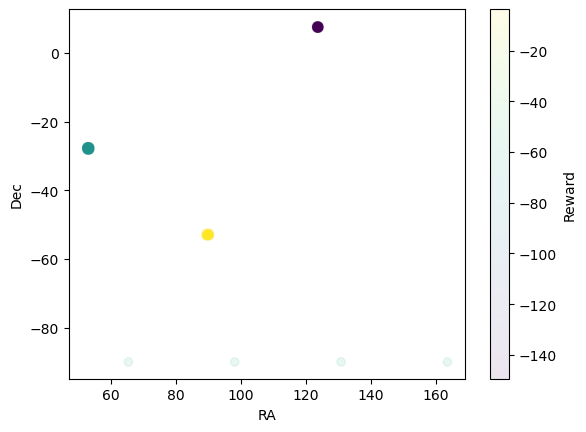

In [10]:
# can look at the reward for each potential observations on the sky
fig, ax = plt.subplots()
ack = ax.scatter(np.degrees(sched.survey_lists[0][0].observations['RA']),
            np.degrees(sched.survey_lists[0][0].observations['dec']),
            c=sched.survey_lists[0][0].reward, alpha=0.1)
cb = plt.colorbar(ack)
cb.set_label('Reward')
ax.set_xlabel('RA')
ax.set_ylabel('Dec')

In [11]:
# How big is it to dump this scheduler
file = open('save_test.pkl', 'wb')
pickle.dump(sched, file)
file.close()
from subprocess import Popen
Popen('ls -lh *.pkl', shell=True)

<Popen: returncode: None args: 'ls -lh *.pkl'>

Pros and cons

Cons:

* Not as modular as using basis function objects
* Setting an altitude limit of observations taken by a `PointingSurvey` object is done differently than in a `BlobSurvey`. (but we have the same issue with `ScriptedSurveys` where the logic on when to execute doesn't use only basis functions.)

Pros

* Scalable. 1 to 1,000,000 potential pointings, no problem. No looping over many survey objects.
* Small memory/storage footprint. 3M uncompressed, <1M compressed. Current Auxtel uncompressed is 157M
* Easy to output debugging data frame analagous to the other surveys
* Easier to configure since all the logic is already in the class. One-liner to make the survey class

## Example removing the 5-sigma depth logic in making decisions on what to observe

In [12]:
# Say we want to lift the m5 and moon limits. Just remove them from the weights dict
weights = {"visit_gap": 1.0, "balance_revisit": 1.0,  "slew_time": -1.0,
           "wind_limit": 0.0, "ha_limit": 0, "alt_limit": 0}
ps = PointingsSurvey(obs, detailers=[], weights=weights)
sched = CoreScheduler([ps])

-rw-r--r--  1 yoachim  staff   4.1M Jan  6 11:44 save_test.pkl


In [13]:
mo = ModelObservatory(downtimes="ideal")
mo, sched, completed_obs = sim_runner(mo, sched, sim_duration=3)

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/surveys/pointings_survey.py:270: RuntimeWarning: invalid value encountered in divide
  result = np.floor(1.0 + self.n_obs / sum_obs)


progress = 33.35%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/skybrightness_pre/sky_model_pre.py:352: UserWarning: Requested MJD between sunrise and sunset, returning closest maps
  warnings.warn("Requested MJD between sunrise and sunset, returning closest maps")


progress = 100.07%Skipped 0 observations
Flushed 0 observations from queue for being stale
Completed 976 observations
ran in 0 min = 0.0 hours


In [14]:
conditions = mo.return_conditions()
sched.survey_lists[0][0].make_reward_df(conditions)

,method,blank,feasible,max_reward,n_possibles,weight,max_accum_reward,accum_n
0,visit_gap,None,True,0.000000,799,1.0,0.000000,799
1,balance_revisit,None,True,1.000000,799,1.0,1.000000,799
2,slew_time,None,True,-61.241754,320,-1.0,-60.241754,320
3,wind_limit,None,True,0.000000,799,0.0,-60.241754,320
4,ha_limit,None,True,0.000000,234,0.0,-108.117466,89
5,alt_limit,None,True,0.000000,369,0.0,-108.117466,89


## Example using Sequence Boost

In [15]:
# Let's try out the sequence boost
obs_boost = obs.copy()

# Say we want to make sure all 4 of seq1 execute, and all 5 in seq2 execute
sequence_boost = {'seq1': 4, 'seq2': 5}
weights = {"visit_gap": 1.0, "balance_revisit": 1.0,  "slew_time": -1.0,
           "wind_limit": 0.0, "ha_limit": 0, "alt_limit": 0, 'sequence_boost': 5.}

# Change the note so scheduler can recognize things as belonging to the same sequence
for i in np.arange(4):
    match = np.where(obs['scheduler_note'] == 'AUXTEL_PHOTO_IMAGINGPhoto1600-1_00%i' % (i+1))[0]
    obs_boost['scheduler_note'][match] = 'seq1_%i' % i

# and say we always want to take 5 of this one in a sequence. Need to give each part of 
# the sequence it's own observation.
match = np.where(obs['scheduler_note'] == 'AUXTEL_PHOTO_IMAGINGPhoto1600-1_020')[0]

five_obs = ObservationArray(5)
for key in five_obs.dtype.names:
    five_obs[key] = obs[match][key].copy()
for i in range(5):
    five_obs[i]["scheduler_note"] = "seq2_%i" % i

obs_boost = np.concatenate([obs_boost, five_obs])

# Here we've used the sequence boost to try and make things be taken in sequences.
# One could also imagine making a detailer that makes sure every time a pointing is selected,
# it gets converted into the desired sequence. 


In [16]:
ps = PointingsSurvey(obs_boost, detailers=[], weights=weights, track_notes_ngoal=sequence_boost)
sched = CoreScheduler([ps])

mo = ModelObservatory(downtimes="ideal")
mo, sched, completed_obs = sim_runner(mo, sched, sim_duration=3)


/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/surveys/pointings_survey.py:270: RuntimeWarning: invalid value encountered in divide
  result = np.floor(1.0 + self.n_obs / sum_obs)


progress = 33.35%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/skybrightness_pre/sky_model_pre.py:352: UserWarning: Requested MJD between sunrise and sunset, returning closest maps
  warnings.warn("Requested MJD between sunrise and sunset, returning closest maps")


progress = 100.07%Skipped 0 observations
Flushed 0 observations from queue for being stale
Completed 976 observations
ran in 0 min = 0.0 hours


In [17]:
conditions = mo.return_conditions()
sched.survey_lists[0][0].make_reward_df(conditions)

,method,blank,feasible,max_reward,n_possibles,weight,max_accum_reward,accum_n
0,visit_gap,None,True,0.000000,804,1.0,0.000000,804
1,balance_revisit,None,True,1.000000,804,1.0,1.000000,804
2,slew_time,None,True,-61.241754,320,-1.0,-60.241754,320
3,wind_limit,None,True,0.000000,804,0.0,-60.241754,320
4,ha_limit,None,True,0.000000,234,0.0,-108.117466,89
5,alt_limit,None,True,0.000000,369,0.0,-108.117466,89
6,sequence_boost,None,True,0.000000,804,5.0,-108.117466,89


In [18]:
# Let's see how the sequences look.
seq_indx = ['seq' in s for s in completed_obs["scheduler_note"]]
df = pd.DataFrame(completed_obs[seq_indx])


In [19]:
# does something different happen with no sequence boost?
weights = {"visit_gap": 1.0, "balance_revisit": 1.0,  "slew_time": -1.0,
           "wind_limit": 0.0, "ha_limit": 0, "alt_limit": 0.}
ps = PointingsSurvey(obs, detailers=[], weights=weights)
sched = CoreScheduler([ps])

mo = ModelObservatory(downtimes="ideal")
mo, sched, completed_obs2 = sim_runner(mo, sched, sim_duration=3)

conditions = mo.return_conditions()
sched.survey_lists[0][0].make_reward_df(conditions)

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/scheduler/surveys/pointings_survey.py:270: RuntimeWarning: invalid value encountered in divide
  result = np.floor(1.0 + self.n_obs / sum_obs)


progress = 33.35%

/Users/yoachim/git_repos/rubin_scheduler/rubin_scheduler/skybrightness_pre/sky_model_pre.py:352: UserWarning: Requested MJD between sunrise and sunset, returning closest maps
  warnings.warn("Requested MJD between sunrise and sunset, returning closest maps")


progress = 100.07%Skipped 0 observations
Flushed 0 observations from queue for being stale
Completed 976 observations
ran in 0 min = 0.0 hours


,method,blank,feasible,max_reward,n_possibles,weight,max_accum_reward,accum_n
0,visit_gap,None,True,0.000000,799,1.0,0.000000,799
1,balance_revisit,None,True,1.000000,799,1.0,1.000000,799
2,slew_time,None,True,-61.241754,320,-1.0,-60.241754,320
3,wind_limit,None,True,0.000000,799,0.0,-60.241754,320
4,ha_limit,None,True,0.000000,234,0.0,-108.117466,89
5,alt_limit,None,True,0.000000,369,0.0,-108.117466,89


In [20]:
# Took the same total number of images, but not the same positions.
check = True
if completed_obs["RA"].size == completed_obs2["RA"].size:
    check = ~np.all(completed_obs["RA"] == completed_obs2["RA"])
print("Did we point differently with the sequence boost on?", check)

Did we point differently with the sequence boost on? False
